In [2]:
using POMDPs
import POMDPs
using QuickPOMDPs: QuickPOMDP
using POMDPTools: Uniform, Deterministic, SparseCat, RandomPolicy
using ParticleFilters: ParticleCollection

# 0. Create a POMDP to work with

In [3]:
tiger = QuickPOMDP(
    states = ["left", "right"],
    actions = ["left", "right", "listen"],
    observations = ["left", "right"],
    initialstate = Uniform(["left", "right"]),
    discount = 0.95,

    transition = function (s, a)
        if a == "listen"
            return Deterministic(s) # tiger stays behind the same door
        else # a door is opened
            return Uniform(["left", "right"]) # reset
        end
    end,

    observation = function (s, a, sp)
        if a == "listen"
            if sp == "left"
                return SparseCat(["left", "right"], [0.85, 0.15]) # sparse categorical distribution
            else
                return SparseCat(["right", "left"], [0.85, 0.15])
            end
        else
            return Uniform(["left", "right"])
        end
    end,

    reward = function (s, a)
        if a == "listen"
            return -1.0
        elseif s == a # the tiger was found
            return -100.0
        else # the tiger was escaped
            return 10.0
        end
    end
)

QuickPOMDP{UUID("0410d3dc-a5e8-4685-b42f-ce6bc37496ad"), String, String, String, NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward), Tuple{Dict{String, Int64}, Bool, Dict{String, Int64}, Vector{String}, Vector{String}, Float64, Vector{String}, var"#2#5", Dict{String, Int64}, Uniform{Set{String}}, var"#1#4", var"#3#6"}}}((stateindex = Dict("left" => 1, "right" => 2), isterminal = false, obsindex = Dict("left" => 1, "right" => 2), states = ["left", "right"], observations = ["left", "right"], discount = 0.95, actions = ["left", "right", "listen"], observation = var"#2#5"(), actionindex = Dict("left" => 1, "right" => 2, "listen" => 3), initialstate = Uniform{Set{String}}(Set(["left", "right"])), transition = var"#1#4"(), reward = var"#3#6"()))

# 1. Create Updater

In [4]:
struct UnweightedPF{M<:POMDP} <: POMDPs.Updater
    m::M
    n_particles::Int
end

In [5]:
function POMDPs.update(up::UnweightedPF, b, a, o)
    new_b = statetype(up.m)[]
    
    while length(new_b) < up.n_particles
        s = rand(b)
        sp, gen_o = @gen(:sp, :o)(up.m, s, a)
        if gen_o == o
            push!(new_b, sp)
        end
    end
    return ParticleCollection(new_b)
end

In [6]:
# POMDPs.initialize_belief(up::UnweightedPF, b0) = rand(b0, up.n_particles)

# 2. Create Policy

In [7]:
struct CertaintyEquivalentGreedyPolicy{M<:POMDP} <: POMDPs.Policy
    m::M
end

In [8]:
function POMDPs.action(p::CertaintyEquivalentGreedyPolicy, b) # b is any distribution, i.e. anything that has pdf defined
    # find most likely state
    s_hat = argmax(s->pdf(b, s), states(p.m))
    
    return argmax(a->reward(p.m, s_hat, a), actions(p.m))
end 

# 3. Create Simulator

(not needed for Homework 6)

In [9]:
struct MySimulator <: POMDPs.Simulator
    epsilon::Float64 # stop if γᵗ is less than this
end

In [10]:
function POMDPs.simulate(sim::MySimulator, m::POMDP, p::Policy, up::Updater)
    b = initialize_belief(up, initialstate(m))
    s = rand(initialstate(m))

    r_total = 0.0
    d = 1.0
    while !isterminal(m, s) && d > sim.epsilon
        a = action(policy, b)
        s, o, r = @gen(:sp,:o,:r)(m, s, a)
        r_total += d*r
        d *= discount(m)
        b = update(up, b, a, o)
    end
    
    return r_total
end

# 4. Run a Simulation

In [11]:
updater = UnweightedPF(tiger, 100)
policy = CertaintyEquivalentGreedyPolicy(tiger)
sim = MySimulator(0.01)
simulate(sim, tiger, RandomPolicy(tiger), updater)

-898.6721680667055

# 5. Create a Solver

(Not needed for Homework 6)

In [12]:
struct CertaintyEquivalentGreedySolver <: POMDPs.Solver end

In [13]:
function POMDPs.solve(::CertaintyEquivalentGreedySolver, m::POMDP)
    return CertaintyEquivalentGreedyPolicy(m)
end

# 6. Mix and Match

In [14]:
using POMDPTools: HistoryRecorder

In [15]:
solver = CertaintyEquivalentGreedySolver()
policy = solve(solver, tiger)
updater = UnweightedPF(tiger, 100)
history = simulate(HistoryRecorder(max_steps=10), tiger, policy, updater)
display([(step.s, step.a, step.r) for step in history])

10-element Vector{Tuple{String, String, Float64}}:
 ("left", "right", 10.0)
 ("right", "left", 10.0)
 ("left", "left", -100.0)
 ("left", "right", 10.0)
 ("left", "left", -100.0)
 ("right", "right", -100.0)
 ("left", "right", 10.0)
 ("right", "right", -100.0)
 ("left", "left", -100.0)
 ("right", "left", 10.0)

In [16]:
using POMDPTools: DiscreteUpdater

In [17]:
updater = DiscreteUpdater(tiger);

In [18]:
hist = simulate(HistoryRecorder(max_steps=10), tiger, policy, updater)
display([step[[:s, :a, :r, :sp]] for step in hist])

10-element Vector{NamedTuple{(:s, :a, :r, :sp), Tuple{String, String, Float64, String}}}:
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "right")
 (s = "right", a = "right", r = -100.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "left")
 (s = "left", a = "right", r = 10.0, sp = "right")
 (s = "right", a = "right", r = -100.0, sp = "left")

# Homework Problem

In [19]:
using DMUStudent.HW6
using POMDPModelTools: render

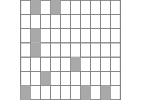

In [20]:
m = LaserTagPOMDP()
render(m)

In [21]:
hist = simulate(HistoryRecorder(max_steps=50), m, CertaintyEquivalentGreedyPolicy(m), DiscreteUpdater(m));

In [22]:
using Interact

WebIO._IJuliaInit()

In [23]:
@manipulate for t in 1:length(hist)
    render(m, hist[t])
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 50, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(25), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/home/zach/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f897db408b0, Task (runnable) @0x00007f897db408b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"47\",\"48\",\"49\",\"50\"],\"changes\":WebIO

# Using POMCP

In [1]:
using BasicPOMCP
using ParticleFilters: particles
using POMDPTools: FunctionPolicy

[ Info: Precompiling BasicPOMCP [d721219e-3fc6-5570-a8ef-e5402f47c49e]


In [24]:
@doc POMCPSolver

```
POMCPSolver(#=keyword arguments=#)
```

Partially Observable Monte Carlo Planning Solver.

## Keyword Arguments

  * `max_depth::Int`   Rollouts and tree expension will stop when this depth is reached.   default: `20`
  * `c::Float64`   UCB exploration constant - specifies how much the solver should explore.   default: `1.0`
  * `tree_queries::Int`   Number of iterations during each action() call.   default: `1000`
  * `max_time::Float64`   Maximum time for planning in each action() call.   default: `Inf`
  * `tree_in_info::Bool`   If `true`, returns the tree in the info dict when action_info is called.   default: `false`
  * `estimate_value::Any`   Function, object, or number used to estimate the value at the leaf nodes.   default: `RolloutEstimator(RandomSolver(rng))`

      * If this is a function `f`, `f(pomdp, s, h::BeliefNode, steps)` will be called to estimate the value.
      * If this is an object `o`, `estimate_value(o, pomdp, s, h::BeliefNode, steps)` will be called.
      * If this is a number, the value will be set to that number

    Note: In many cases, the simplest way to estimate the value is to do a rollout on the fully observable MDP with a policy that is a function of the state. To do this, use `FORollout(policy)`.
  * `default_action::Any`   Function, action, or Policy used to determine the action if POMCP fails with exception `ex`.   default: `ExceptionRethrow()`

      * If this is a Function `f`, `f(pomdp, belief, ex)` will be called.
      * If this is a Policy `p`, `action(p, belief)` will be called.
      * If it is an object `a`, `default_action(a, pomdp, belief, ex)` will be called, and if this method is not implemented, `a` will be returned directly.
  * `rng::AbstractRNG`   Random number generator.   default: `Random.GLOBAL_RNG`


In [26]:
pomcp_solver = POMCPSolver(
    c = 1.0, # adjust the exploration parameter just like in MDP MCTS
    max_time = 0.2, # this should be enough time to get a score in the 30s
    
    # the most important factor for good MCTS (POMCP) performance is the rollout policy
    # since every new leaf node in POMCP contains only one state, it makes sense to run a rollout on the fully observable MDP with FO(Fully Observable)Rollout
    # you can put an MDP policy in here. How would you calculate a good MDP rollout policy? Hint POMDPTools.UnderlyingMDP might help
    estimate_value = FORollout(FunctionPolicy(s->:right)),
    
    default_action=:measure # definitely use this in case there is an error half way through evaluation
)
planner = solve(pomcp_solver, m);

Simulating... 100%|██████████████████████████████████████| Time: 0:00:06


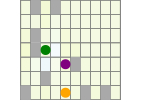

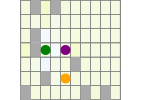

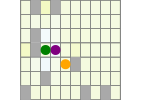

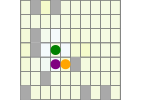

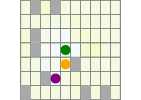

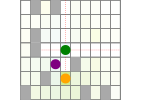

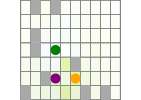

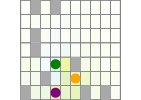

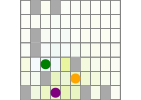

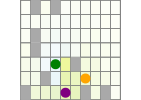

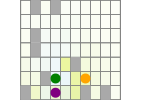

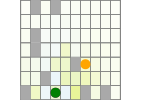

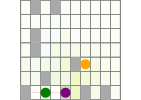

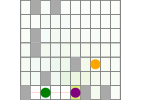

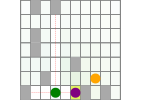

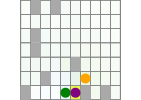

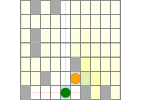

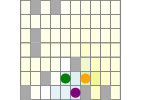

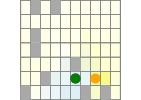

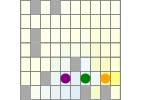

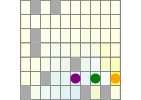

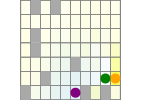

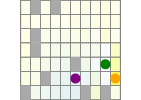

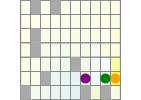

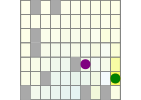

In [27]:
hist = simulate(HistoryRecorder(max_steps=100, show_progress=true), m, planner, DiscreteUpdater(m))
for step in hist
    display(render(m, step))
end